Sensitivity study- using different layers than fc1
====
Note that different layers have very different size outputs- cannot only change one setting at a time. Come back to this.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

import sys
sys.path.insert(0,'../')
from helper import (classification_tools as ct,
                   visualize as vis)
%matplotlib inline

In [2]:
### list of accuracies for final boxplot
features_root = Path('..','data','features')
assert features_root.is_dir()
features_all = [] # list of feature names
accs_all = [] # list of list of all accuracies for each feature 
inertias_all = [] # list of points corresponding to accuracy of clustering with minimum inertia for each feature

In [3]:
le_path = Path('..','models','label_encoder.pickle')
assert le_path.is_file()
with open(le_path, 'rb') as f:
    le = pickle.load(f)

fc2 features
===

In [4]:
fc2_path = features_root / 'VGG16_fc2_features.pickle'
assert fc2_path.is_file()

with open(fc2_path, 'rb') as f:
    fc2_data = pickle.load(f)
fc2_y_gt = le.transform(fc2_data['labels'])

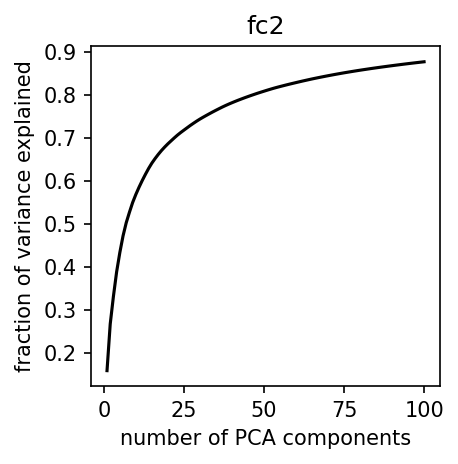

In [5]:
fc2_pca = PCA(n_components=50, svd_solver='full', whiten=True)
fc2_pca_nw = PCA(n_components=50, svd_solver='full', whiten=False)


fc2_pca_n = PCA(svd_solver='full', whiten='False')
fc2_pca_n.fit(fc2_data['features'])

fc2_var = (fc2_pca_n.explained_variance_ratio_[:100]).cumsum()

fig, ax = plt.subplots(figsize=(3,3), dpi=150)
ax.set_xlabel('number of PCA components')
ax.set_ylabel('fraction of variance explained')
ax.set_title(fc2_data['layer_name'])
ax.plot(range(1, len(fc2_var)+1), fc2_var, '-k')
plt.show()

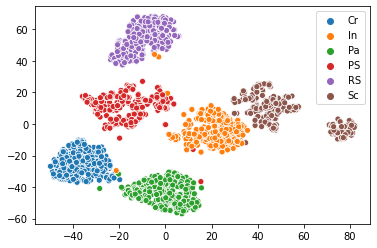

In [7]:
fc2_x_nw = fc2_pca_nw.fit_transform(fc2_data['features'])
fc2_x = fc2_pca.fit_transform(fc2_data['features'])



fc2_tsne = TSNE(n_components=2, random_state=12213)
fc2_x_tsne = fc2_tsne.fit_transform(fc2_x_nw)
fig, ax = plt.subplots()
sns.scatterplot(fc2_x_tsne[:,0], fc2_x_tsne[:,1], hue=fc2_data['labels'], hue_order=le.labels_ordered)
plt.show()

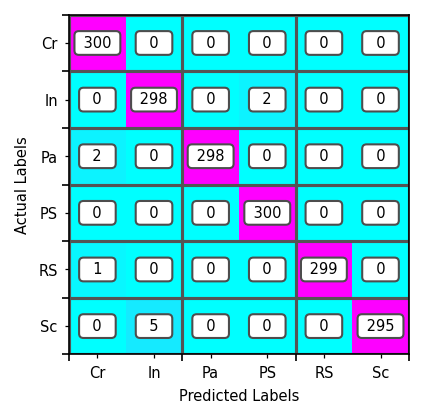

accuracy: 0.994


In [8]:
fc2_cache_path = Path('..','.neu_cache','fc2_features.pickle')
use_cache=True
if not use_cache or not fc2_cache_path.is_file():    
    fc2_kmeans = KMeans(n_clusters=7, init='k-means++', 
                    n_init=500, random_state=634494157)
    fc2_kmeans.fit(fc2_x)
    fc2_labels_unmatched = fc2_kmeans.labels_
    fc2_y_pred = ct.label_matcher(fc2_labels_unmatched, fc2_y_gt)
    fc2_CM = confusion_matrix(fc2_y_gt, fc2_y_pred)
    fc2_acc = fc2_CM.trace()/fc2_CM.sum()
    with open(fc2_cache_path, 'wb') as f:
        pickle.dump((fc2_acc, fc2_CM),f)
else:
    with open(fc2_cache_path, 'rb') as f:
        fc2_acc, fc2_CM = pickle.load(f)
fig, ax = plt.subplots(figsize=(3,3), dpi=150)
vis.pretty_cm(fc2_CM, labelnames=le.labels_ordered, ax0=ax, fs=7, cmap='cool')
plt.show()

print('accuracy: {:.3f}'.format(fc2_acc))

block5_pool features
===

In [9]:
b5p_path = features_root / 'VGG16_block5_pool_features.pickle'
assert b5p_path.is_file()

with open(b5p_path, 'rb') as f:
    b5p_data = pickle.load(f)
b5p_y_gt = le.transform(b5p_data['labels'])

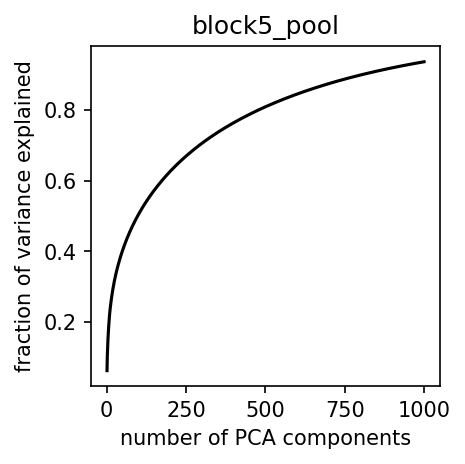

In [10]:
b5p_pca = PCA(n_components=110, svd_solver='full', whiten=True)
b5p_pca_nw = PCA(n_components=110, svd_solver='full', whiten=False)

b5p_features_reshape = b5p_data['features'].reshape(len(b5p_data['features']),-1)
b5p_pca_n = PCA(svd_solver='full', whiten='False')
b5p_pca_n.fit(b5p_features_reshape)

b5p_var = (b5p_pca_n.explained_variance_ratio_[:1000]).cumsum()

fig, ax = plt.subplots(figsize=(3,3), dpi=150)
ax.set_xlabel('number of PCA components')
ax.set_ylabel('fraction of variance explained')
ax.set_title(b5p_data['layer_name'])
ax.plot(range(1, len(b5p_var)+1), b5p_var, '-k')
plt.show()


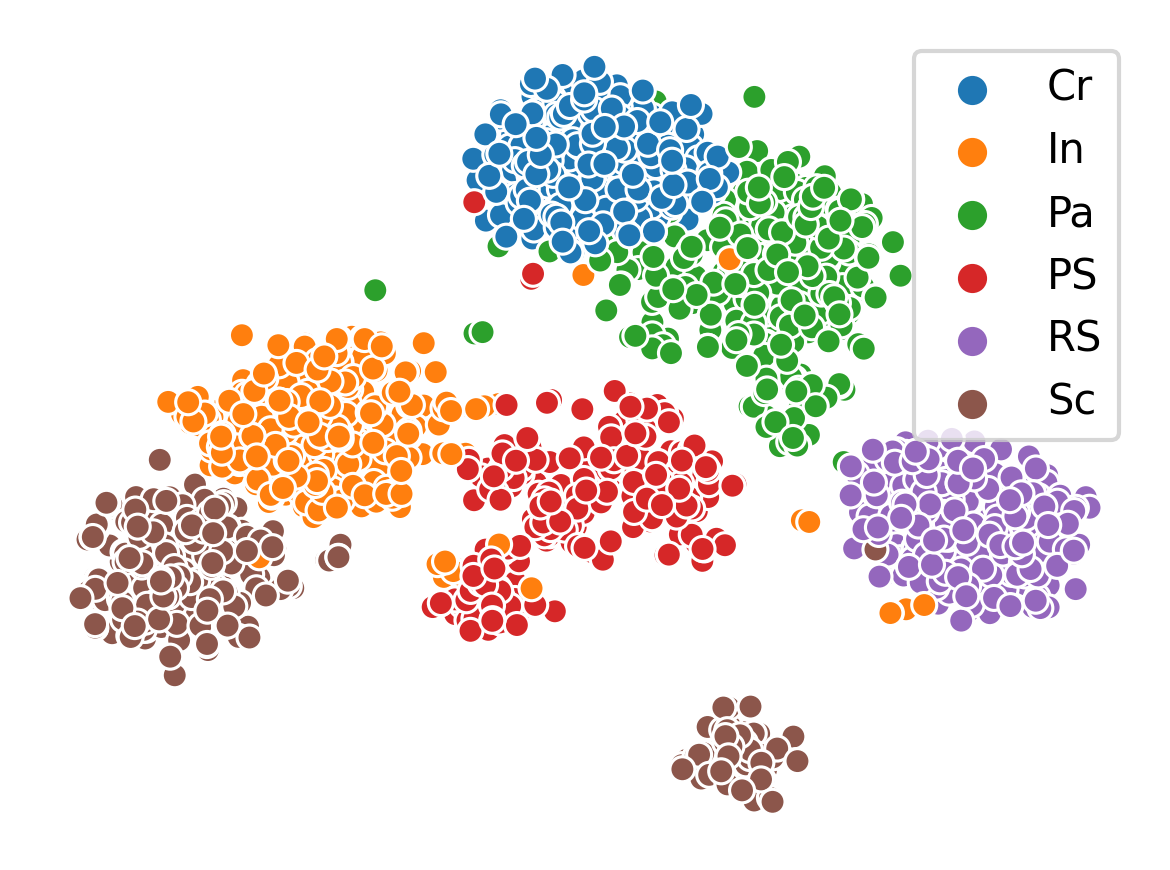

In [16]:
b5p_x_nw = b5p_pca_nw.fit_transform(b5p_features_reshape)
b5p_x = b5p_pca.fit_transform(b5p_features_reshape)


b5p_tsne = TSNE(n_components=2, random_state=12213)
b5p_x_tsne = b5p_tsne.fit_transform(b5p_x_nw)
fig, ax = plt.subplots(figsize=(4,3), dpi=300, facecolor='w')
sns.scatterplot(b5p_x_tsne[:,0], b5p_x_tsne[:,1], hue=b5p_data['labels'], hue_order=le.labels_ordered, ax=ax)
ax.axis('off')
fig.tight_layout()
fig.savefig(Path('..','Figures','b5p_tsne.png'), bbox_inches='tight')
plt.show()


In [12]:
b5p_tsne_kmeans_cache_path = Path('..','.neu_cache','b5p_kmeans_tsne.pickle')
use_cache=True

if not use_cache or not b5p_tsne_kmeans_cache_path.is_file():
    rs_ = np.random.RandomState(3081759952)
    k_values_ = list(range(6,25))
    tsne_cms = []
    for k, state in zip(k_values_, rs_.randint(2**32, size=len(k_values_))):
        b5p_kmeans_tsne = KMeans(n_clusters=k, init='k-means++', n_init=500, random_state=state)
        b5p_kmeans_tsne.fit(b5p_x_tsne)
        b5p_tsne_y_pred = ct.label_matcher(b5p_kmeans_tsne.labels_, b5p_y_gt)
        b5p_tsne_cm = confusion_matrix(b5p_y_gt, b5p_tsne_y_pred)
        print(b5p_tsne_cm)
        tsne_cms.append(b5p_tsne_cm)
    with open(b5p_tsne_kmeans_cache_path, 'wb') as f:
        pickle.dump([k_values_, tsne_cms], f)
else:
    with open(b5p_tsne_kmeans_cache_path, 'rb') as f:
        k_values_, tsne_cms = pickle.load(f)
for k, cm in zip(k_values_, tsne_cms):
    print('k: {:>2}\tacc: {:.3f}'.format(k, cm.trace()/cm.sum()))

k:  6	acc: 0.838
k:  7	acc: 0.964
k:  8	acc: 0.939
k:  9	acc: 0.956
k: 10	acc: 0.952
k: 11	acc: 0.947
k: 12	acc: 0.942
k: 13	acc: 0.941
k: 14	acc: 0.939
k: 15	acc: 0.939
k: 16	acc: 0.959
k: 17	acc: 0.954
k: 18	acc: 0.955
k: 19	acc: 0.973
k: 20	acc: 0.973
k: 21	acc: 0.975
k: 22	acc: 0.974
k: 23	acc: 0.976
k: 24	acc: 0.973


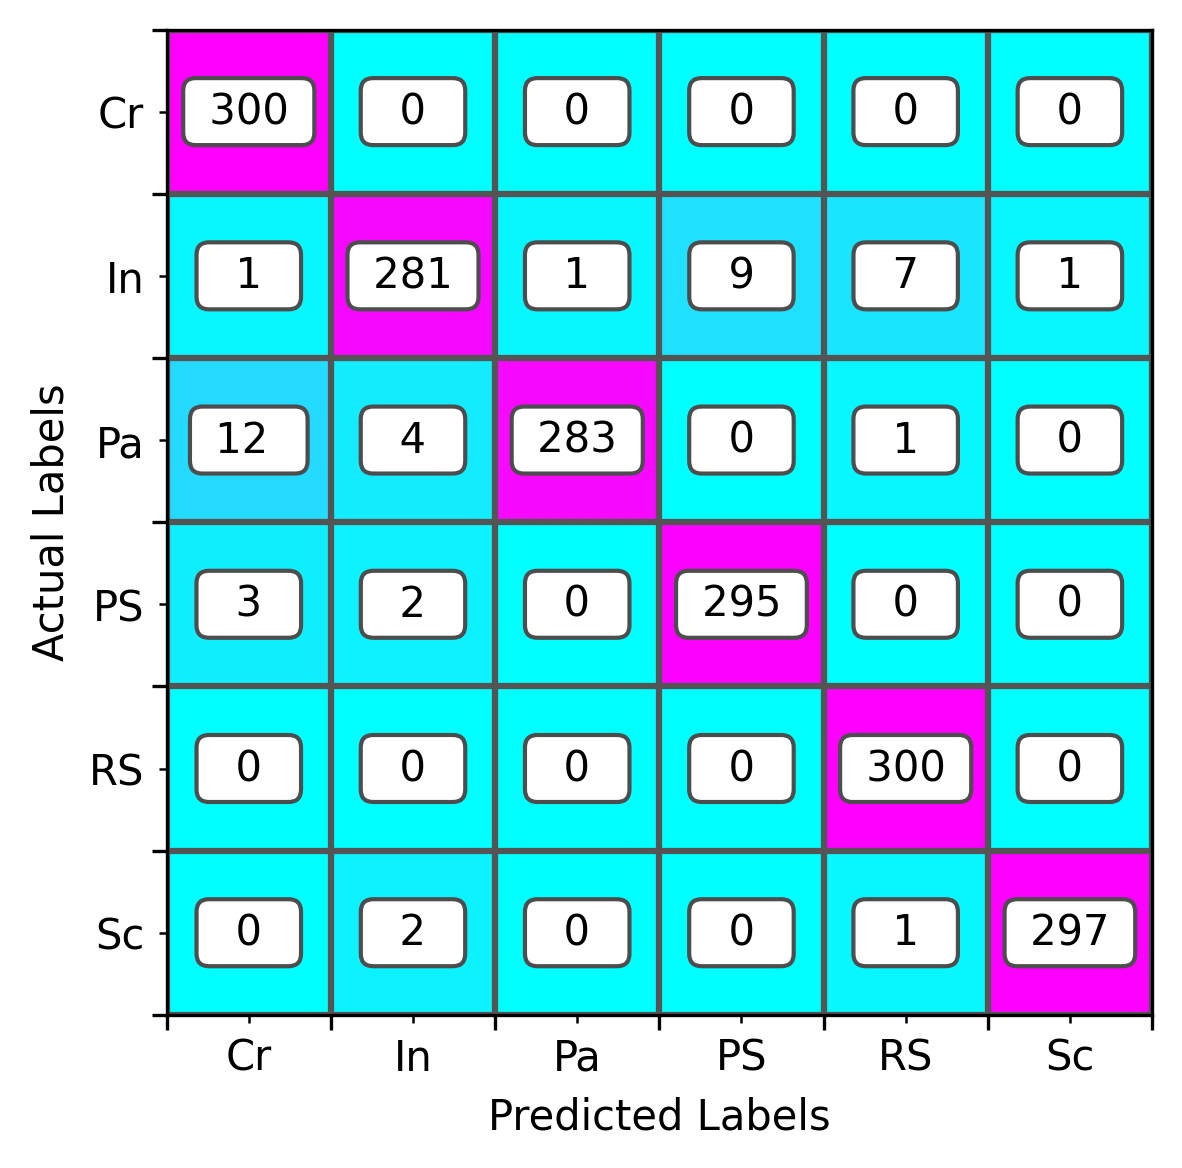

In [19]:
fig, ax = plt.subplots(figsize=(4,4), dpi=300)
vis.pretty_cm(tsne_cms[-2], le.labels_ordered, ax0=ax, fs=10, cmap='cool')
fig.tight_layout()
fig.savefig(Path('..','Figures','b5p_cm.png'), bbox_inches='tight')

In [ ]:
b5p_cache_path = Path('..','.neu_cache','b5p_features_k.pickle')
use_cache=True

if not use_cache or not b5p_cache_path.is_file():
    b5p_klist = list(range(6,20))
    b5p_CMlist=[]
    rs = np.random.RandomState(seed=2296093342)
    for k, state in zip(b5p_klist, rs.randint(2**32, size=len(b5p_klist))):
        b5p_kmeans = KMeans(n_clusters=k, init='k-means++', 
                        n_init=500, random_state=state)
        b5p_kmeans.fit(b5p_x)
        b5p_labels_unmatched = b5p_kmeans.labels_
        b5p_y_pred = ct.label_matcher(b5p_labels_unmatched, b5p_y_gt)
        b5p_CM = confusion_matrix(b5p_y_gt, b5p_y_pred)
        b5p_CMlist.append(b5p_CM)
    with open(b5p_cache_path, 'wb') as f:
        pickle.dump((b5p_klist, b5p_CMlist), f)
else:
    with open(b5p_cache_path, 'rb') as f:
        b5p_klist, b5p_CMlist = pickle.load(f)
for ki, cmi in zip(b5p_klist, b5p_CMlist):
    print('k: {:>2} \taccuracy: {:.3f}'.format(ki, cmi.trace()/cmi.sum()))

In [ ]:
fig, ax = plt.subplots(figsize=(3,3), dpi=150)
vis.pretty_cm(b5p_CMlist[3], le.labels_ordered, cmap='cool', ax0=ax, fs=7)

In [ ]:
b5p_gt, b5p_pred = ct.deconstruct_cm(b5p_CMlist[3])

In [ ]:
print(ct.latex_report(b5p_gt, b5p_pred, le.labels_ordered))

In [ ]:
def deconstruct_cm(cm):
    """
    Turns 2d confusion matrix into 2 1d arrays of ground truth values and predicted values.
    
    The cache saves confusion matrices instead of the actual predictions, but it is more
    convenient to have predictions for the classification report. Note that the order of
    files is not preserved.
    
    Parameters
    ----------
    cm: ndarray
        n_class x n_class array of ints corresponding to the number of predictions for each
        class.
    
    Returns
    --------
    gt, pred: ndarray
        n_class element array of integer ground truth (gt) or predicted (pred) labels
        
    
    
    Examples
    --------
    
    cm = np.asarray([[1,2],[3,4]])
    gt, pred = deconstruct_cm(cm)
    print(gt)
    >>> [0 0 0 1 1 1 1 1 1 1]
    print(pred)
    >>> [0 1 1 0 0 0 1 1 1 1]
    """
    r, c = cm.shape
    assert r == c
    gt = []
    pred = []
    for i in range(r):
        for j in range(c):
            for _ in range(cm[i,j]):
                gt.append(i)
                pred.append(j)
    gt = np.asarray(gt)
    pred = np.asarray(pred)
    return gt, pred


block5 conv3 features
===

In [ ]:
b5c3_path = features_root / 'VGG16_block5_conv3_features.pickle'
assert b5c3_path.is_file()

with open(b5c3_path, 'rb') as f:
    b5c3_data = pickle.load(f)
b5c3_y_gt = le.transform(b5c3_data['labels'])


In [ ]:
b5c3_data['features'].shape

In [ ]:
b5c3_pca = PCA(n_components=200, svd_solver='full', whiten=True)
b5c3_pca_nw = PCA(n_components=200, svd_solver='full', whiten=False)

b5c3_features_reshape = b5c3_data['features'].reshape(len(b5c3_data['features']),-1)
b5c3_pca_n = PCA(svd_solver='full', whiten='False')
b5c3_pca_n.fit(b5c3_features_reshape)

b5c3_var = (b5c3_pca_n.explained_variance_ratio_[:1000]).cumsum()

fig, ax = plt.subplots(figsize=(3,3), dpi=150)
ax.set_xlabel('number of PCA components')
ax.set_ylabel('fraction of variance explained')
ax.set_title(b5c3_data['layer_name'])
ax.plot(range(1, len(b5c3_var)+1), b5c3_var, '-k')
plt.show()

In [ ]:
b5c3_x_nw = b5c3_pca_nw.fit_transform(b5c3_features_reshape)
b5c3_x = b5c3_pca.fit_transform(b5c3_features_reshape)


b5c3_tsne = TSNE(n_components=2, random_state=12213)
b5c3_x_tsne = b5c3_tsne.fit_transform(b5c3_x_nw)
fig, ax = plt.subplots()
sns.scatterplot(b5c3_x_tsne[:,0], b5c3_x_tsne[:,1], hue=b5c3_data['labels'], hue_order=le.labels_ordered)
plt.show()

In [ ]:
b5c3_cache_path = Path('..','.neu_cache','b5c3_features_k.pickle')
use_cache=True

if not use_cache or not b5c3_cache_path.is_file():
    b5c3_klist = list(range(6,20))
    b5c3_CMlist=[]
    rs = np.random.RandomState(seed=1531754964)
    for k, state in zip(b5c3_klist, rs.randint(2**32, size=len(b5c3_klist))):
        b5c3_kmeans = KMeans(n_clusters=k, init='k-means++', 
                        n_init=500, random_state=state)
        b5c3_kmeans.fit(b5c3_x)
        b5c3_labels_unmatched = b5c3_kmeans.labels_
        b5c3_y_pred = ct.label_matcher(b5c3_labels_unmatched, b5c3_y_gt)
        b5c3_CM = confusion_matrix(b5c3_y_gt, b5c3_y_pred)
        b5c3_CMlist.append(b5c3_CM)
    with open(b5c3_cache_path, 'wb') as f:
        pickle.dump((b5c3_klist, b5c3_CMlist), f)
else:
    with open(b5c3_cache_path, 'rb') as f:
        b5c3_klist, b5c3_cmlist = pickle.load(f)
for ki, cmi in zip(b5c3_klist, b5c3_CMlist):
    print('k: {:>2} \taccuracy: {:.3f}'.format(ki, cmi.trace()/cmi.sum()))

In [ ]:
fig, ax = plt.subplots(figsize=(3,3), dpi=150)
vis.pretty_cm(b5c3_CMlist[-2], le.labels_ordered, cmap='cool', ax0=ax, fs=7)